In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SS
import torch
from torchinfo import summary
from torch import nn
import pickle
import random
from sklearn.metrics import confusion_matrix

seed everything for reproducibility

In [2]:
def seed_everything(seed=1234, is_cuda=False):
    """Some configurations for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if is_cuda:
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # torch.cuda.manual_seed(args.seed)
        torch.cuda.manual_seed_all(seed)

read data and divide it into features and label

In [3]:
data = pd.read_csv("D:\PyCharmProject\polyuSubject\COMP5434\data.csv")
x = data.iloc[:,:-1].values
y = data['label'].values
x, y

(array([[5.        , 2.5       , 7.94449216, ..., 0.        , 0.        ,
         0.        ],
        [2.        , 1.        , 7.09837564, ..., 0.        , 0.        ,
         0.        ],
        [4.        , 2.5       , 7.69621264, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [4.        , 2.5       , 8.11969625, ..., 0.        , 0.        ,
         0.        ],
        [6.        , 2.5       , 7.8785342 , ..., 0.        , 0.        ,
         0.        ],
        [5.        , 4.25      , 8.71111388, ..., 0.        , 0.        ,
         0.        ]]),
 array([2, 0, 0, ..., 3, 3, 3], dtype=int64))

Use sklearn.preprocessing.StandardScaler to normalize the data
In order to normalize the test data using the same scale at the part of inference, the scaler is saved using pickle.dump

In [4]:
# scaler
seed_everything(1234, True)
scaler = SS()
x = scaler.fit_transform(x)
pickle.dump(scaler, open('scaler.pkl','wb'))

divide data into train and test parts

In [5]:
seed_everything(1234, True)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=1, test_size=0.2)
xx = torch.tensor(X_train, dtype=torch.float, requires_grad=True)
yy = torch.tensor(Y_train, dtype=torch.long, requires_grad=False)

top1 accuracy calculation

In [6]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

ANN Network definition

In [9]:
seed_everything(1234, True)
class ANN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(50, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),

            nn.Linear(128, 4),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.model(x)
        return x

Adam with the learning rate of 0.0001 is selected to be the optimizer.
For a multi-classification task, CrossEntropyLoss should obviously be chosen as the loss function.

In [10]:
seed_everything(1234, True)
net = ANN()
summary(net)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss_func = torch.nn.CrossEntropyLoss()
batch_size = 128
summary(net)

Layer (type:depth-idx)                   Param #
ANN                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       6,528
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       33,024
│    └─Dropout: 2-4                      --
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       65,792
│    └─Dropout: 2-7                      --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       32,896
│    └─Dropout: 2-10                     --
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      516
│    └─ReLU: 2-13                        --
Total params: 138,756
Trainable params: 138,756
Non-trainable params: 0

Training part
We found that the model fits approximately in 200 epochs. 
We take a mini-batch approach to train the model, and at each epoch, calculate the average loss of all data batches.
In each training round, the parameters are saved according to the test accuracy of the current epoch.

The max test accuracy for ANN model is 80.47.

In [11]:
seed_everything(1234, True)
plot_train_acc = []
plot_test_acc = []
plot_train_loss = []
plot_test_loss = []
best_acc = 0
for epoch in range(200):
    net.train()
    batch_loss = []
    train_all_acc1 = []
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size if start + batch_size < len(X_train) else len(X_train)
        xx = torch.tensor(X_train[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(Y_train[start:end], dtype=torch.long, requires_grad=False)
        out = net(xx)
        loss = loss_func(out, yy)
        acc1, acc5 = accuracy(out, yy, topk=(1, 1))
        # print(acc1)
        train_all_acc1.append(acc1.cpu().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())

    net.eval()
    test_batch_loss = []
    test_all_acc1 = []
    with torch.no_grad():
        for start in range(0, len(X_test), batch_size):
            end = start + batch_size if start + batch_size < len(X_test) else len(X_test)
            single_test_xx = torch.tensor(X_test[start:end], dtype=torch.float, requires_grad=False)
            single_test_yy = torch.tensor(Y_test[start:end], dtype=torch.long, requires_grad=False)
            test_pred = net(single_test_xx)
            test_loss = loss_func(test_pred, single_test_yy)
            test_acc1, test_acc5 = accuracy(test_pred, single_test_yy, topk=(1, 1))
            test_all_acc1.append(test_acc1.cpu().item())
            test_batch_loss.append(test_loss.data.numpy())

    train_acc = max(train_all_acc1)
    test_acc = max(test_all_acc1)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), './best_model_2.pth')
    train_loss_epoch = np.mean(batch_loss)
    test_loss_epoch = np.mean(test_batch_loss)
    plot_train_acc.append(train_acc)
    plot_test_acc.append(test_acc)
    plot_train_loss.append(train_loss_epoch)
    plot_test_loss.append(test_loss_epoch)
    if epoch % 10 == 0:
        print(epoch, train_acc, test_acc, best_acc)


0 30.46875 28.90625 28.90625
10 64.84375 64.84375 64.84375
20 74.21875 72.65625 73.4375
30 77.34375 72.65625 73.4375
40 74.21875 75.0 75.78125
50 80.46875 76.5625 76.5625
60 81.25 77.34375 78.125
70 79.6875 77.34375 78.125
80 82.03125 78.125 78.90625
90 82.03125 76.5625 78.90625
100 80.46875 77.34375 78.90625
110 82.8125 76.5625 78.90625
120 81.25 78.125 78.90625
130 82.03125 78.90625 78.90625
140 82.8125 78.125 79.6875
150 82.8125 78.90625 79.6875
160 82.8125 78.90625 79.6875
170 84.375 78.90625 80.46875
180 86.71875 78.90625 80.46875
190 85.15625 79.6875 80.46875


Plot the training process

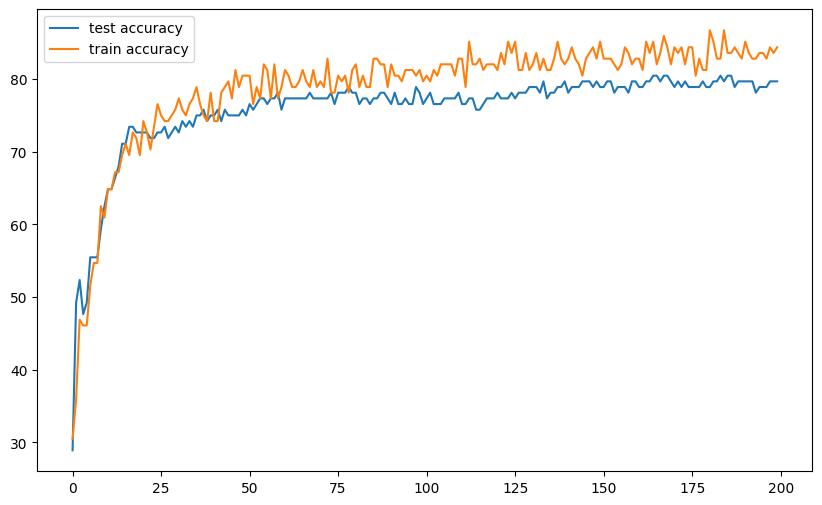

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), plot_test_acc)
plt.plot(range(0, 200), plot_train_acc)
plt.legend(['test accuracy', 'train accuracy'])
plt.show()

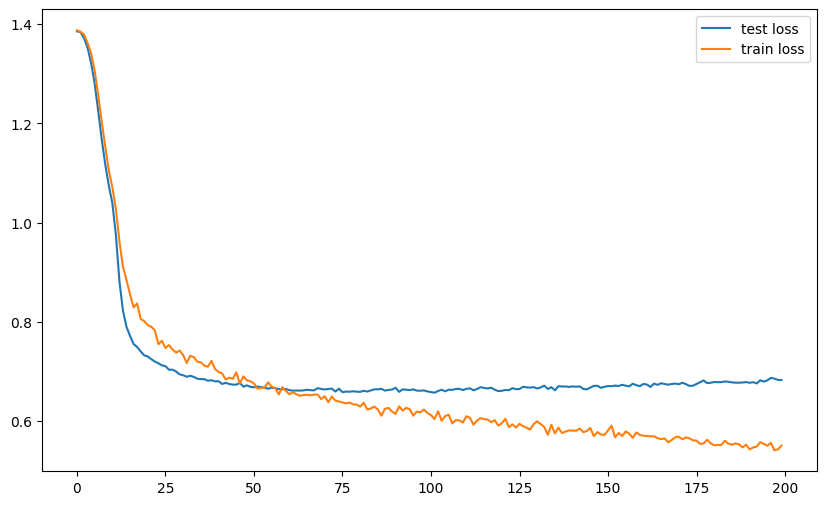

In [13]:
plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), plot_test_loss)
plt.plot(range(0, 200), plot_train_loss)
plt.legend(['test loss', 'train loss'])
plt.show()

During the inference process, scaler.pkl and best_model_2.pth are loaded for normalization and forward calculation respectively.

In [15]:
# inference
test_data = pd.read_csv(r'D:\PyCharmProject\polyuSubject\COMP5434\test_data.csv')
x_test = test_data.values
scaler = pickle.load(open('scaler.pkl', 'rb'))
x_test = scaler.transform(x_test)
inference_net = ANN()
inference_net.load_state_dict(torch.load('best_model_2.pth'))
res = []
x_test = torch.tensor(x_test, dtype=torch.float, requires_grad=False)
for i in range(len(x_test)):
    out = inference_net(x_test[i])
    out = out.detach().numpy().tolist()
    label = out.index(max(out))
    res.append(label)
res

[3,
 1,
 0,
 3,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 3,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 3,
 1,
 0,
 1,
 1,
 3,
 1,
 0,
 3,
 3,
 0,
 3,
 0,
 3,
 3,
 1,
 3,
 3,
 1,
 3,
 2,
 1,
 2,
 0,
 1,
 2,
 1,
 3,
 3,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 3,
 0,
 0,
 0,
 1,
 2,
 3,
 1,
 1,
 1,
 2,
 2,
 1,
 3,
 1,
 1,
 3,
 3,
 3,
 1,
 3,
 2,
 3,
 3,
 2,
 3,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 3,
 2,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 3,
 1,
 3,
 2,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 3,
 0,
 3,
 0,
 3,
 1,
 3,
 2,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 2,
 3,
 2,
 3,
 0,
 0,
 2,
 1,
 2,
 3,
 1,
 2,
 3,
 3,
 2,
 1,
 1,
 0,
 3,
 2,
 3,
 0,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 3,
 3,
 3,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 3,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 3,
 1,
 1,
 3,
 1,
 3,
 2,
 1,
 3,
 1,
 3,
 3,
 0,
 1,
 2,
 0,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 0,
 3,
 1,
 3,
 2,
 3,
 3,
 1,
 3,


save the result

In [16]:
pd.DataFrame(np.array(res).reshape((-1,1))).to_csv("test_res_ANN.csv")

In [17]:
pd.DataFrame(np.array(plot_test_acc).reshape((-1,1))).to_csv("Test_acc.csv")